In [5]:
import pandas as pd 
import numpy as np
import pymc3 as pm
import theano.tensor as tt
from pymc3.math import invlogit
from IPython.display import Image

import seaborn as sns
%matplotlib inline

/jupyter_virtual_envs/python2/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Quick overview of Bayesian thinking.
If you've encountered Bayes' theorem before, the below formula will look familiar. The references at the end will be good material if you need to teach yourself this :) 

This framework never resonated with me until I read John K. Kruschke's book "Doing Bayesian Data Analysis" and saw the below formula through the lens of his beautifully simple Bayesian graphical models.

$$\overbrace{p(\mu \ |\ Data)}^{\text{posterior}} = \dfrac{\overbrace{p(Data \ | \ \mu)}^{\text{likelihood}} \cdot \overbrace{p(\mu)}^{\text{prior}}}{\underbrace{p(Data)}_{\text{marginal likelihood}}}$$


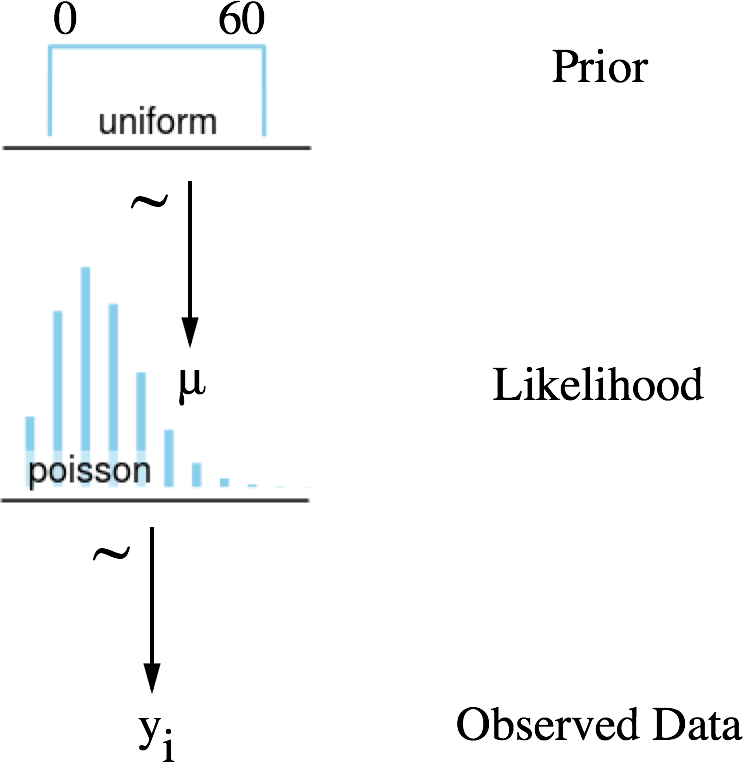

In [6]:
Image('poisson_dag.png', width=320)

The above schema can be interpreted as follows (from the bottom up):

* We observe counts of data (y) for each conversation i (Observed Data)
* This data was generated by a random process which we believe can be represented as a Poisson distribution (Likelihood)
* This Poisson distribution has a single parameter μ which we know is between 0 and 60 (Prior)
   * We will model μ as a uniform distribution because we do not have an opinion as to where within this range to expect it

## The magical mechanics of MCMC 
The process of Markov Chain Monte Carlo (MCMC) is nicely illustrated in the below animation. The MCMC sampler draws parameter values from the prior distribution and computes the likelihood that the observed data came from a distribution with these parameter values.
$$\overbrace{p(\mu \ |\ Data)}^{posterior} \varpropto \overbrace{p(Data \ | \ \mu)}^{likelihood} \cdot \overbrace{p(\mu)}^{prior}$$

This calculation acts as a guiding light for the MCMC sampler. As it draws values from the paramater priors, it computes the likelihood of these paramters given the data - and will try to guide the sampler towards areas of higher probability.

In a conceptually similar manner to the frequentist optimization technique (which we've probably seen before) the MCMC sampler wanders towards areas of highest likelihood. However, the Bayesian method is not concerned with findings the absolute maximum values - but rather to traverse and collect samples around the area of highest probability. All of the samples collected are considered to be a credible parameter.

In [7]:
Image(url='mcmc-animate.gif')

We don't have time to go into the intricacies of Bayesian thinking. There's loads to learn - and there are links at the bottom which might be handy. 

The advantage is we get measures of uncertainty. The other advantage is we can do lots of multiple comparison tests, by *modelling it explicitly*. 

# Introduction to Bayesian A/B testing. 
* We're going to introduce Bayesian A/B testing. 

Imagine the following scenario: You work for a company that gets most of its online traffic through ads. Your current ads have a 3% click rate, and your boss decides that's not good enough. The marketing team comes up with 26 new ad designs, and as the company's data scientist, it's your job to determine if any of these new ads have a higher click rate than the current ad.

You set up an online experiment where internet users are shown one of the 27 possible ads (the current ad or one of the 26 new designs). After two weeks, you collect the data on each ad: How many users saw it, and how many times it was clicked on.

Time to run some statistical tests! New design A vs current design? No statistically significant difference. New design B vs current design? No statistically significant difference. You keep running test and continue getting not significant results. Just as you are about lose hope, new design Z v. current design.... statistically significant difference at the alpha = 0.05 level!

You tell your boss you've found a design that has a higher click rate than the current design, and your company deploys it in production. However, after two months of collecting statistics on the new design, it seems the new design has a click rate of 3%. What went wrong?

When performing A/B testing, data scientists often fall into the common pitfall of failing to correct to for multiple testing. Testing at alpha = 0.05 means your statistical test yielding a result as extreme or more extreme by random chance (assuming a given null hypothesis is true) occurs with probability 0.05. If you run 26 statistical tests, then an upper bound on the expected number of false positives is 26*0.05 = 1.3. This means in our above scenario, our data scientist can expect to have at least one false positive result, and unfortunately, the false positive result is the one she reported to her boss.

![img](https://blog.dominodatalab.com/wp-content/uploads/2016/05/significant.png)

# Let's do a more interesting model. 

We're going to look at self driving cars. 

![img](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS_oBUNqc4hlumhEqgRxhx4rAep9djPXzyeNXaUjAmKS8kFP0IF)


![img](https://venturebeat.com/wp-content/uploads/2016/05/Ubercar.jpg?fit=578%2C325&strip=all)

* Self Driving Cars are one of the more exciting applications of AI. I find personally a lot of the commentary on this to be a bit vacuuous. 
* I'm not convinced self driving cars are safe, and reality holds precedent over Public Relations. I'm old fashioned I believe in reality. 

**In MA there were 0.52 fatalities/100 million miles driven. Since 2009 Google has driven ~1.5 million miles without a crash – does this convince you that self-driving cars are safe?**

Being low on coffee and feeling difficult, I objected to the premise for two reasons: (This example is stolen from one of the PyMC3 contributors).

We’re comparing a rate (0.52 fatalities/100M miles) to a number (0 fatalities)
Google probably drives in California, not Massachusetts

In searching for the California fatality rate, I found a beautiful data set that allowed me to essentially copy and paste the case study for hierarchical partial pooling from the PyMC3 documentation and the Stan documentation. That study was estimating batting averages early in the season, and pooling over different players. We will pool our data over the states, and change the response from a Binomial distribution (did the batter hit?) to a Poisson distribution (how many fatalities occured during the period?)

In [32]:
df_fatality = pd.read_csv('fatality.csv')

KeyError: 'index'

In [40]:
del df_fatality['Unnamed: 0']

In [41]:
# Pandas did not detect most columns as numeric, so we can cast them all here
df_fatality[df_fatality.columns[1:]] = df_fatality[df_fatality.columns[1:]].apply(pd.to_numeric)

# Extract the data we need as numpy arrays
miles_e6 = (df_fatality['Annual VMT (Millions)']).as_matrix()
fatalities = df_fatality['Total Highway Fatalities'].as_matrix()

## Build a hierachical model
We assume that there is a distribution of fatality rates, and each state has a background rate drawn from there. We really should model state-level effects more carefully before applying this pooling, but life is short. We additionally assume that google's cars have a fatality rate drawn from the same distribution. This is a prior we could argue over, but it seems reasonable, given our lack of other experiments with self driving cars.

In our pooled_rate, we assume that nothing is known about state averages, so we pick a uniform distribution. 

We also, introduce a hyperparameter $\textrm{k}$ to account for the variance between the population rates of fatalities, and we use a bounded Pareto distribution. 

This will ensure that the estimated value falls within reasonable bounds. These hyperparameters will be, in turn used to parameterise a beta distribuiton, which ideal for modelling quantities on the unit interval. 

Intuitively, pooled_rate is the probability of probabilities, and state_rate is a vector of length 51 (DC is a state?), with estimates for their own true fatality rates. I model state rate self-driving fatality rate as a separate variable, but in the same way, as google rate.

Our final step is to specify a sampling distribution for the data - in our case we're trying to estimate a 'count'. So Poisson suits, if we were trying to estimate a 'hit or miss' so a binary variable we'd use a Binomial distribution. 

For what it is worth, I used the exact model from the PyMC3 documentation (with y being Binomial distributed instead of Poisson), and came to qualitatively the same conclusions.


We'll stick in uber fatalities and in uber miles. The google number is a bit out of date. But we'll leave it for the moment, and just compare the updated thing below. 

In [44]:
def car_model(miles, fatalities, google_miles=1.5, google_fatalities=0, uber_miles=2.0, uber_fatalities=1):
    with pm.Model() as model:
        pooled_rate = pm.Uniform('pooled_rate', lower=0.0, upper=1.0)
        k_log = pm.Exponential('k_log', lam=1.5)
        k = pm.Deterministic('k', tt.exp(k_log))

        state_rate = pm.Beta('state_rate', 
                             alpha=pooled_rate*k, 
                             beta=(1.0-pooled_rate)*k, 
                             shape=len(fatalities))
        observed_fatalities = pm.Poisson('y', mu=state_rate*miles, observed=fatalities)

        google_rate = pm.Beta('google_rate', 
                              alpha=pooled_rate*k, 
                              beta=(1.0-pooled_rate)*k)
        observed_google_fatalities = pm.Poisson('y_new', 
                                                mu=google_miles*google_rate, 
                                                observed=google_fatalities)
       
        uber_rate = pm.Beta('uber_rate', 
                              alpha=pooled_rate*k, 
                              beta=(1.0-pooled_rate)*k)
        observed_uber_fatalities = pm.Poisson('y_new_uber', 
                                                mu=uber_miles*uber_rate, 
                                                observed=uber_fatalities)
        
        
    return model

In [45]:

with car_model(miles_e6, fatalities):
    trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named mkl
100%|██████████| 10500/10500 [00:35<00:00, 293.06it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9aa78dbc10>,
      dtype=object)

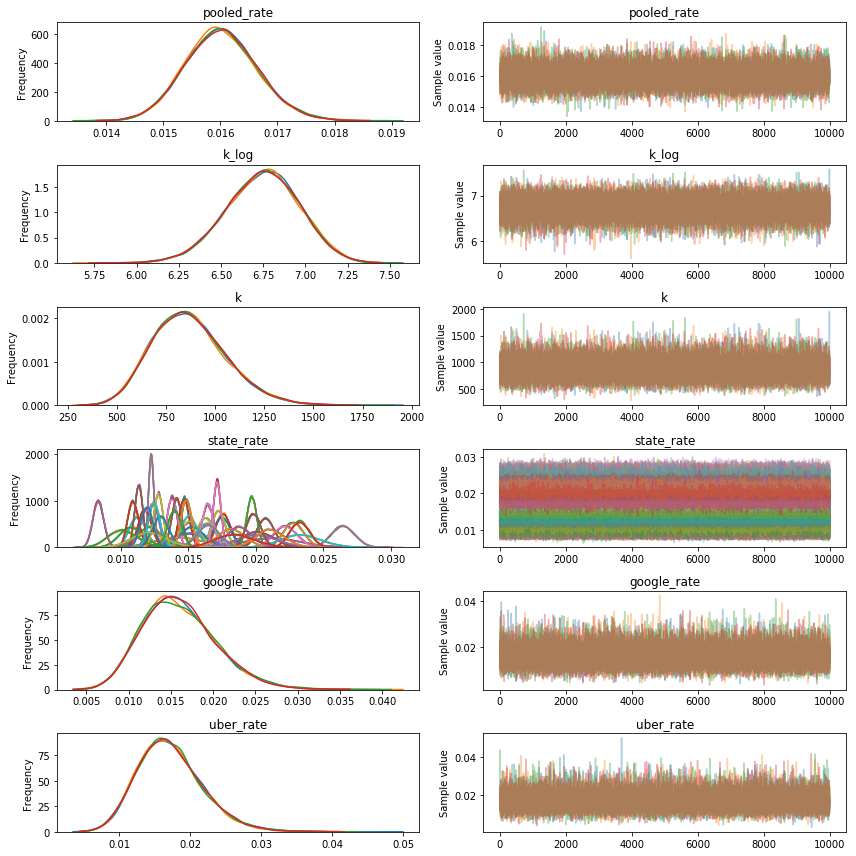

In [46]:
pm.traceplot(trace)

## Answering the question
The original question was whether I trust Google's self driving cars, given the fatality rate in MA. I don't, yet. 

In [47]:
plt.style.use('seaborn-talk')


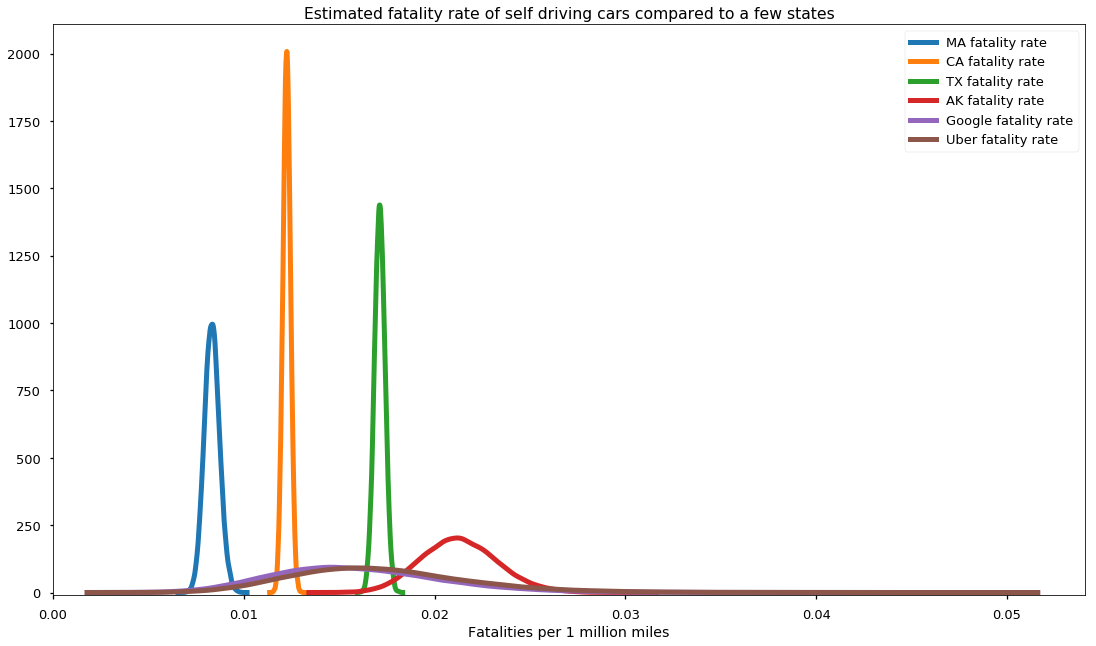

In [48]:

fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
for state in ('MA', 'CA', 'TX', 'AK'):
    sns.distplot(trace['state_rate'][:, df_fatality.State == state], label='{} fatality rate'.format(state), **shared_kwargs)
sns.distplot(trace['google_rate'], label='Google fatality rate', **shared_kwargs)
sns.distplot(trace['uber_rate'], label='Uber fatality rate', **shared_kwargs)

fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_ylim(ymin=-10)
ax.set_title('Estimated fatality rate of self driving cars compared to a few states')
ax.set_xlabel('Fatalities per 1 million miles')

ax.legend();

## Update. 
Let's say we figure out (which we can because we get more data) that Waymo has driven 4 million miles. 
How does that change our conclusions? Not much! This is reasonable, since the average state has 50 billion miles in the dataset, so moving from 1.5million to 4million should not change the inference very much.

In [49]:
with car_model(miles_e6, fatalities, google_miles=4.):
    updated_trace = pm.sample(10000, njobs=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 10500/10500 [00:35<00:00, 298.60it/s]


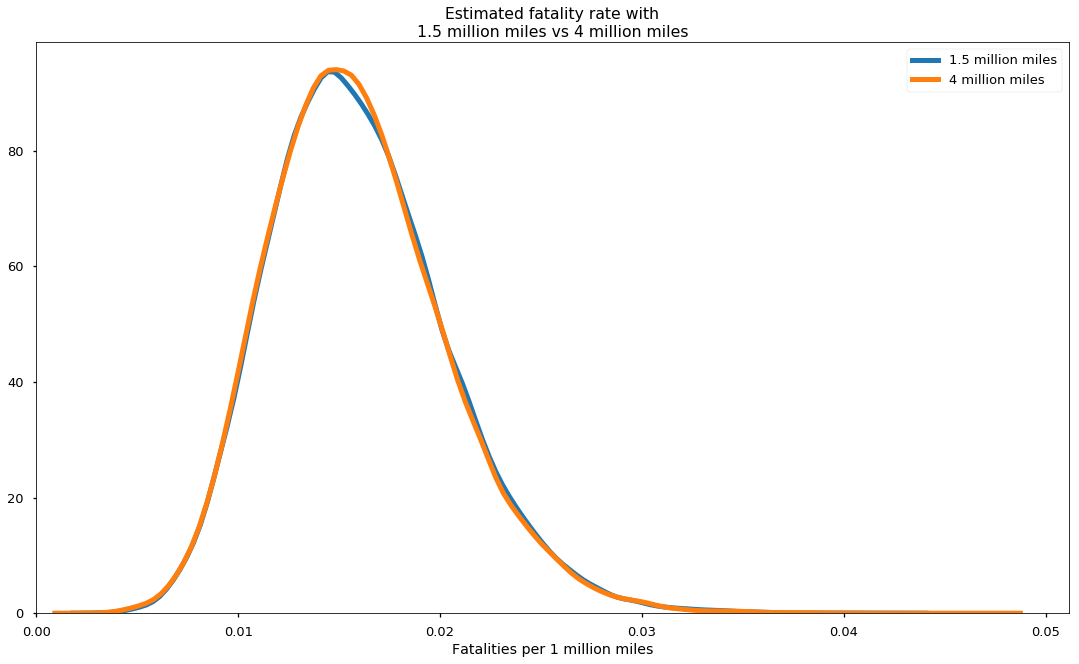

In [50]:
plt.style.use('seaborn-talk')
fig, ax = plt.subplots(1, 1)
shared_kwargs = {'hist': False, 'ax': ax, 'kde_kws': {'linewidth': 5}}
sns.distplot(trace['google_rate'], label='1.5 million miles', **shared_kwargs)
sns.distplot(updated_trace['google_rate'], label='4 million miles', **shared_kwargs)
fig.set_size_inches(18.5, 10.5)
ax.set_xlim(xmin=0)
ax.set_title('Estimated fatality rate with\n1.5 million miles vs 4 million miles')
ax.set_xlabel('Fatalities per 1 million miles')
ax.legend();

## Now what does this have to do with A/B tests. 
Well we can consider this first A/B test was between MA and Google. However what about all 50 states plus DC. And this could be say 'lots of channels' in Direct Mail or it could be all the types of mobile phone (by device).

Lots of times in life you'll have multiple comparisons :) 


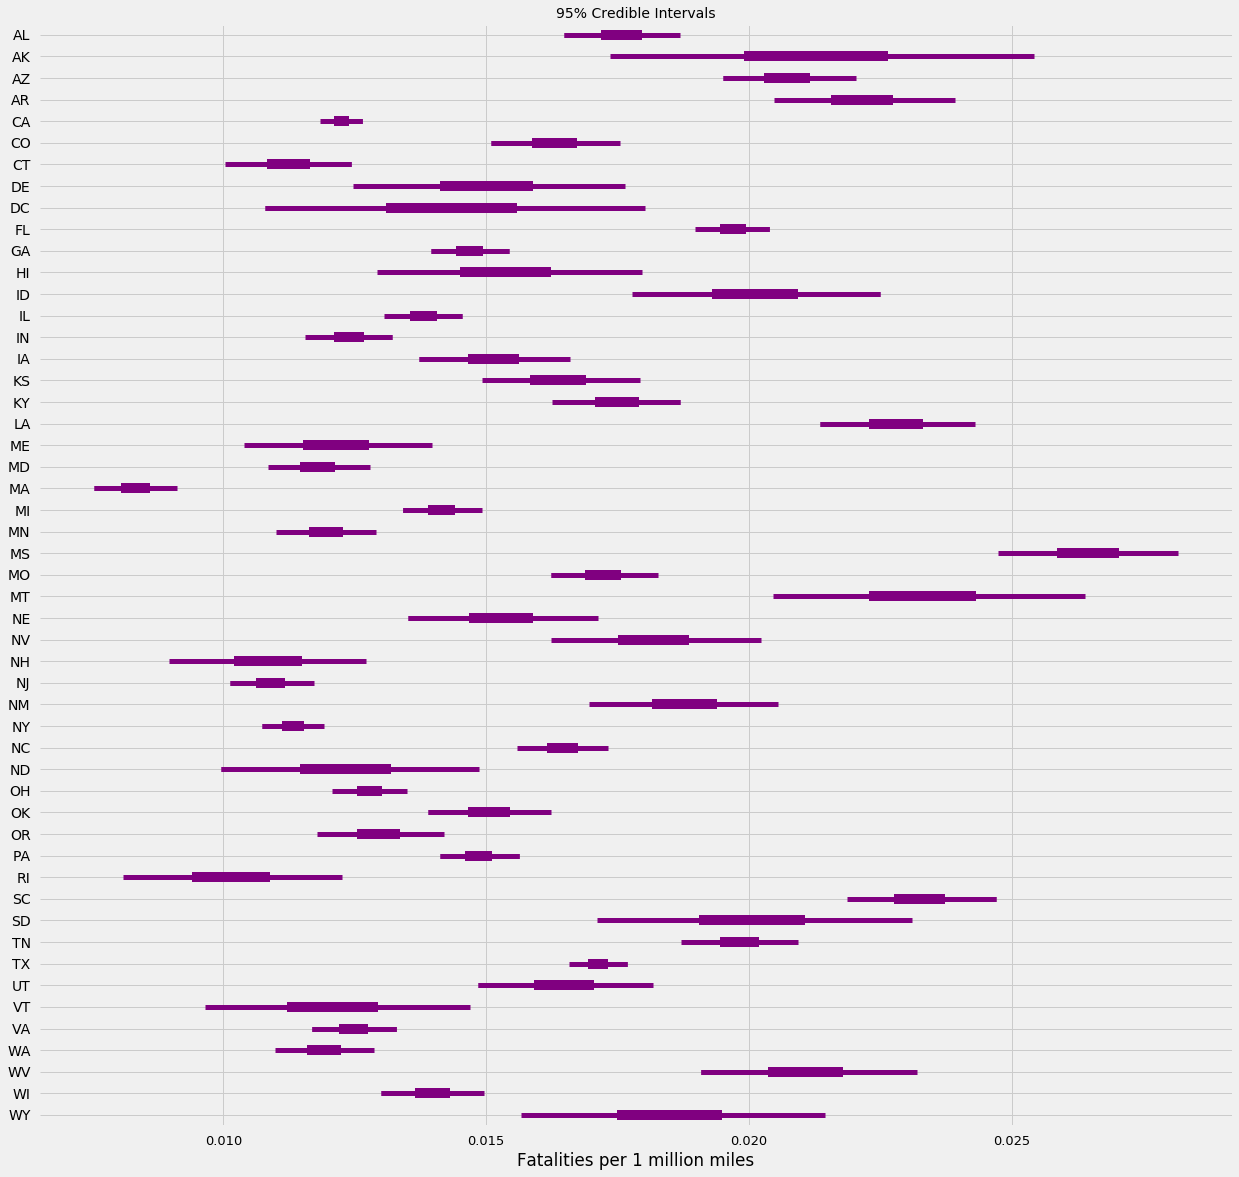

In [79]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (18, 18)
plt.style.use('fivethirtyeight')
pm.forestplot(trace, ('state_rate',), 
              chain_spacing=0, 
              ylabels=df_fatality.State, 
              rhat=False, 
              xtitle="Fatalities per 1 million miles",
             plot_kwargs={"linewidth": 10, 'color': 'purple'});

In a commercial setting you'd be concerned about something like conversions per 1000 users. Or something similar. 
However we got an A/B test with 51 comparisons out of this model FOR FREEE. 

We didn't need to do anything like [boneforri correction](https://en.wikipedia.org/wiki/Bonferroni_correction) AND we got uncertainty for free. 

### Some literature (with remarks on easy to hard)

**Easy**
- https://github.com/markdregan/Bayesian-Modelling-in-Python (Easy)
- https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers (Easy)

**Medium - you need some understanding of Bayesian for this**
- http://varianceexplained.org/r/beta_binomial_baseball/ (Medium)
- https://www.countbayesie.com/blog/2015/4/25/bayesian-ab-testing
- https://joomik.github.io/abtesting/ (Medium)
- https://making.lyst.com/2014/09/04/testing-continuous-variables/ (Medium)

**Hard - these are more for specialists** 
- http://docs.pymc.io/notebooks/hierarchical_partial_pooling.html (Hard)
- http://www.stat.columbia.edu/~gelman/research/published/multiple2f.pdf (Hard)